In [2]:
import os

# os.chdir('./AMLS_19-20_Muhammad_Juzaimi_SN16072927')
os.chdir('./AMLS_19-20_SN16072927')
# os.chdir('./B1')
print(os.path.abspath(os.curdir))


C:\Users\arez_\PycharmProjects\AMLS_19-20_Muhammad_Juzaimi_SN16072927\AMLS_19-20_SN16072927


In [41]:
from keras.preprocessing import image
import cv2
import dlib
import numpy as np

# PATH TO ALL IMAGES
global basedir, image_paths, target_size
# os.chdir('..')
basedir = './Datasets'
images_dir = os.path.join(basedir, 'img_cartoon')
labels_filename = 'labels_cartoon.csv'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('chin.dat')

def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((34, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [34])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [17, 2])

    return dlibout, resized_image

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def extract_features_labels():
    """
    This funtion extracts the landmarks features for all images in the folder 'dataset/cartoon'.
    It also extracts the shape label for each image.
    :return:
        landmark_features:  an array containing 68 landmark points for each image in which a face was detected
        shape_labels:      an array containing the shape label (0, 1, 2, 3, 4) for each image in
                            which a face was detected
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    labels_file = open(os.path.join(basedir, labels_filename), 'r')
    lines = labels_file.readlines()
    shape_labels = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]}
    # all_features = None
    # all_labels = None
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        img_error = []
        for img_path in image_paths:
            file_name = img_path.split('.')[1].split('\\')[-1]

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(shape_labels[file_name])
            if features is None:
                img_error.append(file_name)

    landmark_features = np.array(all_features)
    shape_labels = np.array(all_labels) # simply converts the -1 into 0, so male=1 and female=0
    return landmark_features, shape_labels, img_error

In [26]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle

X, y, error = extract_features_labels()
Y = np.array([y, -(y - 1)]).T

scaler = StandardScaler()
temp = X.reshape(len(X), 17*2)
temp_X = scaler.fit_transform(temp)
temp_Y = list(zip(*Y))[0]

with open('X_B1.dat', 'wb') as f:
    pickle.dump(temp_X, f) 
    
with open('Y_B1.dat', 'wb') as f:
    pickle.dump(temp_Y, f) 

In [3]:
from data_preprocessing import get_data_B1

tr_X_B1, te_X_B1, tr_Y_B1, te_Y_B1 = get_data_B1()

In [6]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

def SVM_B1(training_images, training_labels, test_images, test_labels):
    tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100]},
                        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                        {'kernel': ['poly'], 'degree': [2, 3], 'C': [1, 10, 100]}
                        ]


    classifierB1 = GridSearchCV(svm.SVC(), tuned_parameters, n_jobs=-1)  # gridsearchCV use 3 k-fold by default
    classifierB1.fit(training_images, training_labels)
    classifierB1_best = classifierB1.best_estimator_
    
# default score of SVM is accuracy   
    print("Best SVM parameter:", classifierB1.best_params_)
    print("Best SVM score:", classifierB1.best_score_)

# print dataframe  
    results = pd.concat([pd.DataFrame(classifierB1.cv_results_["params"]), pd.DataFrame(classifierB1.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
       
# make prediction using the best classifier
    predB1 = classifierB1.best_estimator_.predict(test_images)
    
    return predB1, results, classifierB1_best

In [7]:
import time
starttime = time.time()
predB1, results, classifierB1_best = SVM_B1(tr_X_B1, tr_Y_B1, te_X_B1, te_Y_B1)
stoptime = time.time()
print(stoptime - starttime)

Best SVM parameter: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best SVM score: 0.7773308957952467


152.96795177459717


In [8]:
results

,C,kernel,gamma,degree,Accuracy
0,1,linear,NaN,NaN,0.754113
1,10,linear,NaN,NaN,0.750823
2,100,linear,NaN,NaN,0.749543
3,1,rbf,0.0010,NaN,0.640402
4,1,rbf,0.0001,NaN,0.467459
5,10,rbf,0.0010,NaN,0.748263
6,10,rbf,0.0001,NaN,0.640402
7,100,rbf,0.0010,NaN,0.777331
8,100,rbf,0.0001,NaN,0.745887
9,1,poly,NaN,2.0,0.546618


[0.8 0.8 0.8 0.8 0.8]
[0.72 0.76 0.77 0.77 0.78]


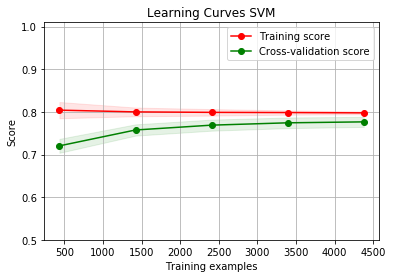

In [70]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    print(train_scores_mean)
    print(test_scores_mean)
    
    return plt

title = "Learning Curves SVM"

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = classifierB1_best
X, y = tr_X_B1, tr_Y_B1
plot_learning_curve(estimator, title, X, y, (0.5, 1.01), cv=cv, n_jobs=-1)

plt.show()

# default test score for SVM is accuracy

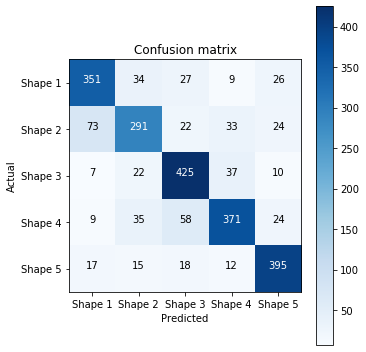

In [33]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,normalize=False):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
dict_characters = {0 : 'Shape 1', 1 : 'Shape 2', 2: 'Shape 3', 3: 'Shape 4', 4: 'Shape 5'}


confusion_mat = confusion_matrix(te_Y_B1, predB1)
plot_confusion_matrix(confusion_mat, classes = list(dict_characters.values()))


In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print("Accuracy:", accuracy_score(te_Y_B1, predB1))
print("Precision:", precision_score(te_Y_B1, predB1, average = 'macro'))
print("Recall:", recall_score(te_Y_B1, predB1, average = 'macro'))
print("F1:", f1_score(te_Y_B1, predB1, average = 'macro'))

Accuracy: 0.7816631130063966
Precision: 0.780288445761925
Recall: 0.7802469291134202
F1: 0.7791798210416563


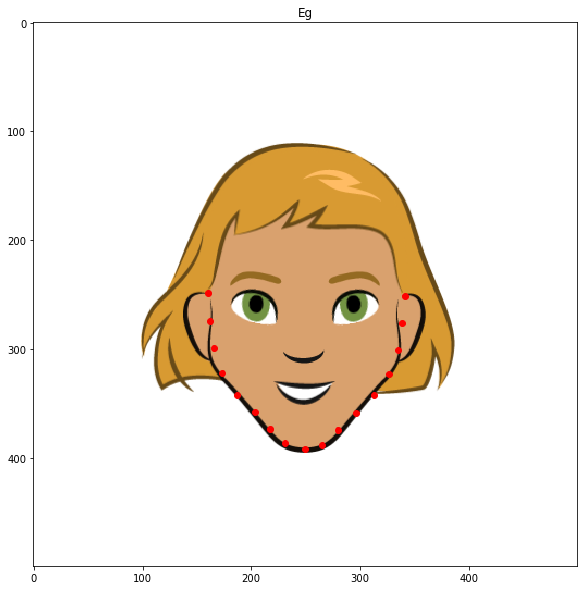

In [47]:
import matplotlib.pyplot as plt
from keras.preprocessing import image

basedir = './Datasets'
images_dir = os.path.join(basedir, 'img_cartoon')
ex_img_path = os.path.join(images_dir, '81.png')
ex_img = image.img_to_array(image.load_img(ex_img_path, target_size = None, interpolation='bicubic'))
ex_feat, _ = run_dlib_shape(ex_img)



x, y = np.split(ex_feat, 2, axis=1)
cv_image = cv2.imread(ex_img_path)
fig = plt.figure(figsize=(10, 10))
image_plot = plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
plt.title("Eg")
plt.scatter(x, y, c='red')
plt.show()

In [67]:
print(len(tr_X_B1) + len(te_X_B1))

7815
